In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import argparse
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import numpy as np
import torch
from torch import nn
import torch.optim.adam
from torch.utils.data import TensorDataset, DataLoader

In [8]:
class simple_network(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3840, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),

            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        # self.linear_relu_stack.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)

    def forward(self, x):
        # x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [9]:
def train_model(model, epochs, train_dataloader, test_dataloader, checkpoint_path, loss_fn= nn.BCELoss(), optimizer = torch.optim.Adam, device = "cuda:0", verbose=False):
    
    model = model().to(device)
    optimizer = optimizer(model.parameters(), lr=0.0001)
    best_loss = 99999
    history = []
    best_epoch = 0
    for t in range(epochs):
        # print(f"Epoch {t+1}\n-------------------------------")
        train_a, train_l = run_train(train_dataloader, model, loss_fn, optimizer, device, verbose)
        test_acc, test_l = run_test(test_dataloader, model, loss_fn, device)
        history.append({"epoch":t, "accuracy": train_a, "loss": train_l, "phase": "train"})
        history.append({"epoch":t, "accuracy": test_acc, "loss": test_l, "phase": "test"})
        if test_l < best_loss:
            print(f"new low! {test_l}")
            torch.save(model.state_dict(), checkpoint_path)
            best_loss = test_l
            best_epoch = t
        
        print(f"Epoch: {t}, train a/l: {train_a:>0.3f}/{train_l:>0.3f} test a/l: {test_acc:>0.3f}/{test_l:>0.3f}")
    print(f"Best loss: {best_loss}, best epoch: {best_epoch}")

    print("Done!")
    return model, history


def run_train(dataloader, model, loss_fn, optimizer, device, v):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    total_accuracy, total_loss = 0, 0
    for batch, (X, y) in enumerate(dataloader):

        X, y = X.to(device), y.to(device)
        if v: print(f"shape X : {X.shape}")
        if v: print(f"X : {X}")

        if v:print(f"shape y : {y.shape}")
        if v:print(f"y : {y.tolist()}")

        pred = model(X)

        if v:print(f"shape pred: {pred.shape}")
        if v:print(f"pred: {pred}")
        if v:print(f"pred round: {pred.round().tolist()}")
        if v:print(f"pred accuracy: {(pred.round() == y).tolist()}")

        # Should I add round here aswell ?
        loss = loss_fn(pred, y)
        if v:print(f"loss: {loss.tolist()}")
        # print(loss.shape)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss +=  loss.item()
        # print(pred)
        
        total_accuracy += (pred.round() == y).type(torch.float).sum().item()
        
        # if batch % 20 == 0:
        #     loss, current = loss.item(), (batch + 1) * len(X)
        #     accuracy = (pred.round() == y).type(torch.float).sum().item() / size
        #     print(f"loss: {loss:>7f}, accuracy:{100*accuracy:>0.1f}  [{current:>5d}/{size:>5d}]")

    total_loss /= num_batches
    total_accuracy /= size
    return total_accuracy, total_loss

def run_test(dataloader, model, loss_fn, device):

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
    
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.round() == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

def run_validation(model, dataloader,  loss_fn= nn.BCELoss(), device = "cuda:0"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    prediction = []
    labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
    
            pred = model(X)
            prediction.extend(pred.cpu())
            labels.extend(y.cpu())

            test_loss += loss_fn(pred, y).item()
            correct += (pred.round() == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    print(f"validation Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return prediction, labels
    
def plot_auc(preds, labels, out):
    viz = RocCurveDisplay.from_predictions(labels, preds, pos_label=True)
    viz.plot()
    plt.savefig(str(out)+"auc_val.png", dpi=300, bbox_inches="tight")
    # plt.show()

def plot_history(hist, out):
    df = pd.DataFrame(hist)
    # print(df.head())
    plt.figure()
    lp = sns.lineplot(data=df, x="epoch", y="accuracy", hue="phase")
    lp.figure.savefig(str(out)+"accuracy.png")
    
    plt.figure()
    lp = sns.lineplot(data=df, x="epoch", y="loss", hue="phase")
    lp.figure.savefig(str(out)+"loss.png")


def make_dataloaders(input, batch_size, sample=None, name="", v=False):
    df = pd.read_csv(input, sep="\t", header=0, index_col=0)
    print(df.shape)
    if name:
        df1 = df.query('similar == False').sample(n=int(sample/2), random_state=42)
        df2 = df.query('similar == True').sample(n=int(sample/2), random_state=42)
        df = pd.concat([df1, df2])
        df.to_csv(name, sep="\t")
    
    df.em_x = df.em_x.apply(eval)
    df.em_y = df.em_y.apply(eval)

    samples = df.em_x + df.em_y
    x = np.array(samples.values.tolist())
    scaler = StandardScaler()
    scaler.fit(x)
    x_scaled = scaler.transform(x)
    y = df.similar.astype(int).values   

    if v: print(f"len x : {len(x)}")
    if v: print(f"x : {x}")
    if v: print(f"len y : {len(y)}")
    if v: print(f"y : {y}")
    dl = DataLoader(
        TensorDataset(
            torch.tensor(x_scaled, dtype=torch.float32), 
            torch.tensor(y, dtype=torch.float32).unsqueeze(1)
            ), 
        batch_size=batch_size, shuffle=True
        )
    
    return dl

Making train loader
(90, 10)
Making test loader
(23, 10)
new low! 0.6924863457679749
Epoch: 0, train a/l: 0.567/0.693 test a/l: 0.435/0.692
Epoch: 1, train a/l: 0.522/0.688 test a/l: 0.522/0.702
Epoch: 2, train a/l: 0.611/0.673 test a/l: 0.522/0.693
Epoch: 3, train a/l: 0.533/0.683 test a/l: 0.565/0.701
Epoch: 4, train a/l: 0.567/0.678 test a/l: 0.609/0.708
Epoch: 5, train a/l: 0.578/0.672 test a/l: 0.565/0.723
Epoch: 6, train a/l: 0.567/0.675 test a/l: 0.609/0.733
Epoch: 7, train a/l: 0.600/0.657 test a/l: 0.609/0.747
Epoch: 8, train a/l: 0.656/0.663 test a/l: 0.565/0.755
Epoch: 9, train a/l: 0.633/0.657 test a/l: 0.565/0.763
Epoch: 10, train a/l: 0.600/0.657 test a/l: 0.478/0.759
Epoch: 11, train a/l: 0.600/0.666 test a/l: 0.522/0.741
Epoch: 12, train a/l: 0.733/0.647 test a/l: 0.522/0.757
Epoch: 13, train a/l: 0.556/0.665 test a/l: 0.348/0.772
Epoch: 14, train a/l: 0.633/0.680 test a/l: 0.478/0.796
Epoch: 15, train a/l: 0.622/0.647 test a/l: 0.478/0.789
Epoch: 16, train a/l: 0.656/0

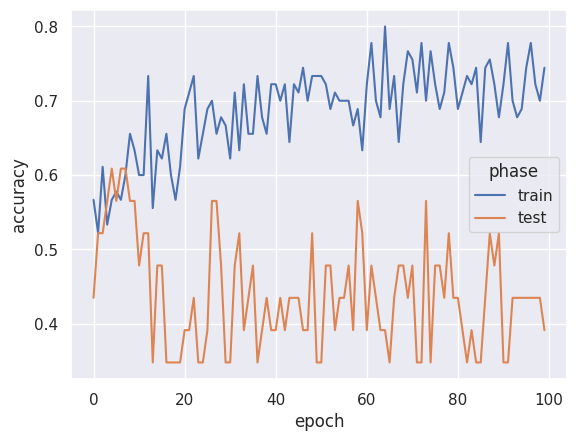

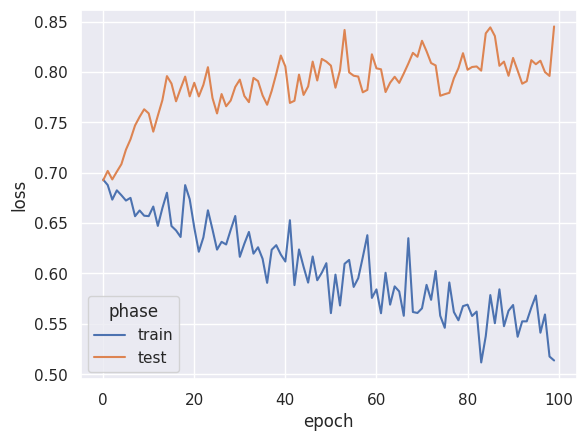

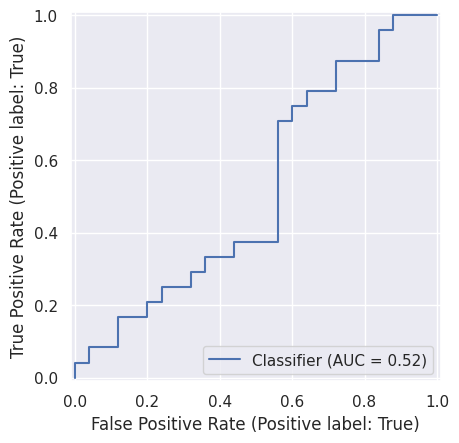

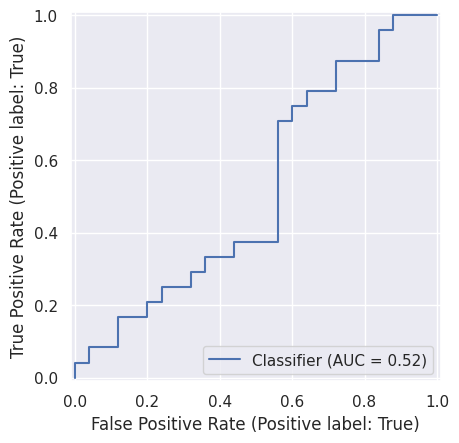

In [10]:
model = "simple"
train_path = Path("data/ath_bol_aar/sm3_train.tsv")
test_path = Path("data/ath_bol_aar/sm3_test.tsv")
val_path = Path("data/ath_bol_aar/sm3_val.tsv")
output_prefix = Path("results/testing/sm3")
checkpoint_path = Path("saved_models/sm3")
batch_size = 8
epochs = 100
validation = True

model_names = {"simple": simple_network}
if model in model_names:
    model = model_names[model]
else: raise ValueError(f"cannot find model with name {model}")

print("Making train loader")
train_loader = make_dataloaders(train_path, batch_size, v=False)

print("Making test loader")
test_loader = make_dataloaders(test_path, batch_size, v=False)

model, history = train_model(model, epochs, train_loader, test_loader, checkpoint_path=checkpoint_path, verbose=False)
plot_history(history, output_prefix)

model = model_names["simple"]

model = model().to("cuda:0")
model.load_state_dict(torch.load(checkpoint_path, weights_only=True))
model.eval()

if validation:
    print("Making val loader")
    val_loader = make_dataloaders(val_path, batch_size)
    pred, labels = run_validation(model, val_loader)
    plot_auc(pred, labels, output_prefix)